# 1. Introduction

This is a notebook for a past kaggle competition [**HuBMAP - Hacking the Human Vasculature**.](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature) The goal of this competition is to detect Blood Vessels from images of kidney tissue taken by microscope, and detecton mask shall have [IoU (Intersection over Union)](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/) greater than 0.6. The kaggle score is calculated by Average Precision Over Confidence which is the same as [Open Images 2019 - Instance Segmentation](https://www.kaggle.com/c/open-images-2019-instance-segmentation/overview/evaluation). 

This HuBMAP competition seems to be difficult for few reasons. First, it looks almost impossible to correctly identify blood vessels by non-experts(refer to EDA). It would be hard for deep learning too. Second, only 1633 label data are given for images which is insufficient for such a complex segemtation. Another reason is imbalanced label: only 3.3% of image pixels are positive. Therefore, I defined following targets for this project. 

**Target**

* To develop an effective training loop which includes **data augmentation** and **custom loss function**
* To compare score and calculation time between two well-known model (**FCN and U-NET**)
* **Average IoU > 0.5** in validation data when **20% of images are selected for validation**.
* To submit prediction to kaggle

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import time
import math
import json

import tensorflow as tf
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# 2. Data

There are 1633 training images with their label (`polygon`), tile information (`tile_df`) which indicate datasource and source wsi. Source wsi is profiles of human subjects described in`wsi_df`.

**Data Source**

https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/data

In [2]:
train_folder = "/kaggle/input/hubmap-hacking-the-human-vasculature/train/"
test_folder = "/kaggle/input/hubmap-hacking-the-human-vasculature/test/"
wsi_fpath = "/kaggle/input/hubmap-hacking-the-human-vasculature/wsi_meta.csv"
tile_fpath = "/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv"
sample_fpath = "/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv"
polygon_fpath = "/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl"

In [3]:
with open(polygon_fpath) as f:
    polygon = [json.loads(line) for line in f]
    
NP = len(polygon)

In [4]:
print("N of train data = ", NP)

N of train data =  1633


In [5]:
train_files = os.listdir(train_folder)
tile_df = pd.read_csv(tile_fpath)
wsi_df = pd.read_csv(wsi_fpath)
sample_df = pd.read_csv(sample_fpath)

In [6]:
tile_df

id  source_wsi  dataset      i      j
0     0006ff2aa7cd           2        2  16896  16420
1     000e79e206b7           6        3  10240  29184
2     00168d1b7522           2        2  14848  14884
3     00176a88fdb0           7        3  14848  25088
4     0033bbc76b6b           1        1  10240  43008
...            ...         ...      ...    ...    ...
7028  ffd37b5c6598          13        3  13824  21504
7029  ffd3d193c71e           3        2   7680  16896
7030  ffd77e2517af          13        3  15872  28160
7031  ffe3cbb81f72          10        3  15456  23000
7032  ffe40e3bc324           9        3  13824  19456

[7033 rows x 5 columns]

In [7]:
wsi_df

source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5

In [8]:
train_fnames = []
for i in range(NP):
    train_fnames.append(polygon[i]["id"])
    
train_name_df = pd.DataFrame({"id":train_fnames})
train_name_df["count"] = 1

tile_df = pd.read_csv(tile_fpath)
tile_df = tile_df.merge(train_name_df, on = "id", how = "left")
tile_df = tile_df.query("count > 0")

**Reading Images**

This code read images from folder. 

In [9]:
time1 = time.time()
i = 0
L = 512
X_train = np.zeros((NP, L, L, 3), dtype =  np.uint8)

for i in range(NP):
    #cv2 read images as BGR that should be converted into RGB
    img = cv2.imread(train_folder + train_fnames[i] + ".tif")[:,:,::-1]    
    X_train[i,:,:,:] = img
    
time2 = time.time()
time3 = np.round(time2 - time1)
print(time3, "sec")

51.0 sec


# 3. Data Cleaning

Quality fo image is good and unnecessary to clean. The problem is that the label is given as polygon (geometry) data. For image segmentation, it shall be converted to pixelwise label. This operation is accomplished by [other notebook](https://www.kaggle.com/code/hidetaketakahashi/hubmap-create-mask). Put simply, it checks whether pixels are in polygon or not by breath-first-seach. BFS (starts from one of polygon element) significantly reduced calculation time compared with checking all the elements. 

In [10]:
# This data is pixel wise label creatated by other notebook
label_mat = np.load("/kaggle/input/hubmap-label/mask_mat.npy")
label_mat[label_mat > 1] = 0
label_mat = label_mat.reshape(NP, 512, 512, 1)

In [11]:
#This is code to copy polygon data into matrix 

nv = len(polygon[0]["annotations"])

vmat =np.zeros((512, 512), dtype =  np.uint8)

for i in range(nv):
    type1 = polygon[0]["annotations"][i]["type"]
    if type1 == "blood_vessel":
        crd = polygon[0]["annotations"][i]["coordinates"][0]
        
        for x, y in crd:
            #pixels in polygon line is 1, otherwize 0
            vmat[y, x] = 1

Following figure shows one of given image, its corresponding label, and pixel wise label.

Text(0.5, 1.0, 'pixel wise label (preprocessed)')

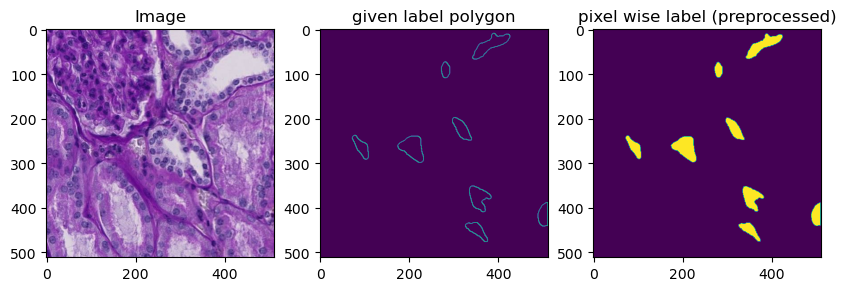

In [12]:
fig, ax = plt.subplots(1,3, figsize = (10, 3))

ax[0].imshow(X_train[0])
ax[1].imshow(vmat)
ax[2].imshow(label_mat[0])

ax[0].set_title("Image")
ax[1].set_title("given label polygon")
ax[2].set_title("pixel wise label (preprocessed)")


# 4. EDA

## 4.1 Basic Information

Images and labels are provided from two datasets and four sources (persons). Number of data is not equal between them. Kaggle test data is taken from only dataset1, but they are invisible for participants. 

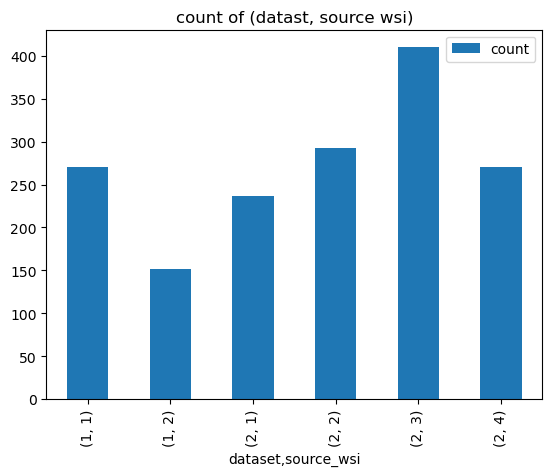

In [13]:
select = ["dataset", "source_wsi", "count"]

sum_data_df = tile_df[select].groupby(select[0:-1]).sum().astype(int)
sum_data_df.plot(kind = "bar", title = "count of (datast, source wsi)")
plt.show()

In [14]:
def plot_photo(img, title = ""):
    
    N = img.shape[0]
    
    NC = 5
    NR =  math.ceil(N/NC)
    fig, ax = plt.subplots(NR, NC, figsize = (12, NR*2.3))
    
    for k in range(N):
        i =  int(k/NC)
        j = k % NC
        
        if N <= 5:
            ax[j].imshow(img[k])
            ax[j].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        else:
            ax[i,j].imshow(img[k])
            ax[i,j].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
    
    if title != "":
        if N <= 5:
            ax[2].set_title(title)
        else:
            ax[0,2].set_title(title)

## 4.2 Images and Labels

Next, images and labels are visualized by each dataset and source (person). Size and quantity of blood vessels are different between sources. 

In [15]:
#This code select some samples from each dataset and source
np.random.seed(1)

samples_ds = []
for ds in [1,2]:
    filter1 = tile_df["dataset"]==ds
    samples = []
    for wsi in [1,2,3,4]:
        
        if ds ==1:
            if wsi in [1,2]:
                filter2 = filter1 & (tile_df["source_wsi"] == wsi)
                s_idx = np.random.choice(np.where(filter2)[0], 50)
                
        else:
            filter2 = filter1 & (tile_df["source_wsi"] == wsi)
            s_idx = np.random.choice(np.where(filter2)[0], 50)
            
        samples.append(s_idx)
        
    samples_ds.append(samples)


**Dataset1**

In the dataset 1, source 1 contains larger size but small number of blood vessels, whereas source 2 has many smaller size blood vessels. 

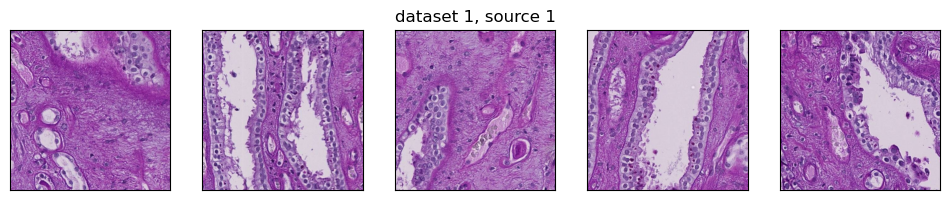

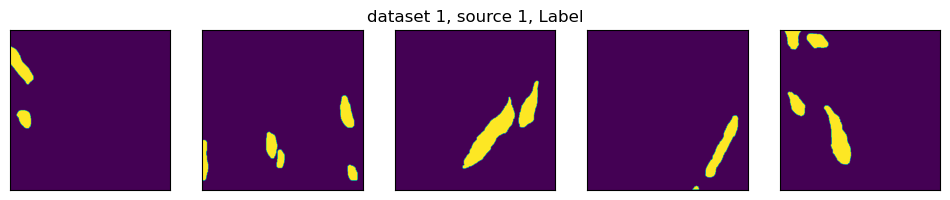

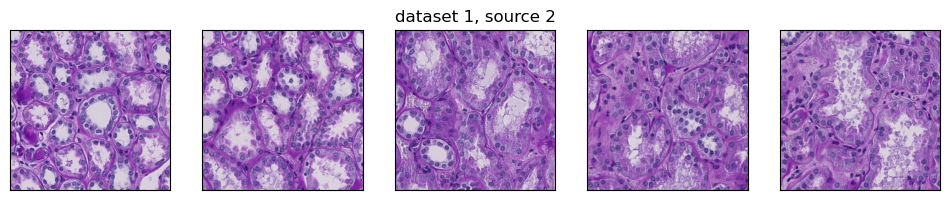

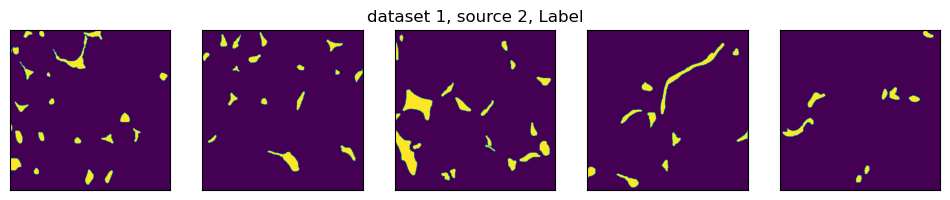

In [16]:
plot_photo(X_train[samples_ds[0][0][0:5]], "dataset 1, source 1")
plot_photo(label_mat[samples_ds[0][0][0:5]], "dataset 1, source 1, Label")
plot_photo(X_train[samples_ds[0][1][0:5]], "dataset 1, source 2")
plot_photo(label_mat[samples_ds[0][1][0:5]], "dataset 1, source 2, Label")

**Dataset 2**

Image and labels of dataset 2 looks similar to dataset 1, but their color is slightly different. 

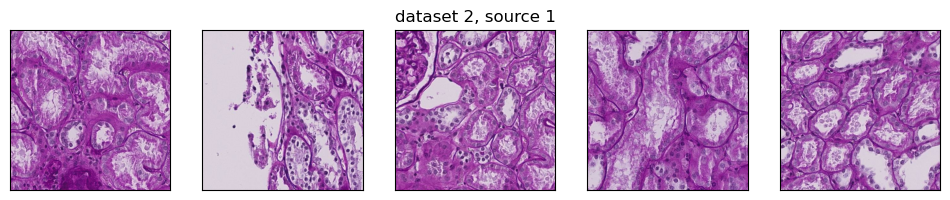

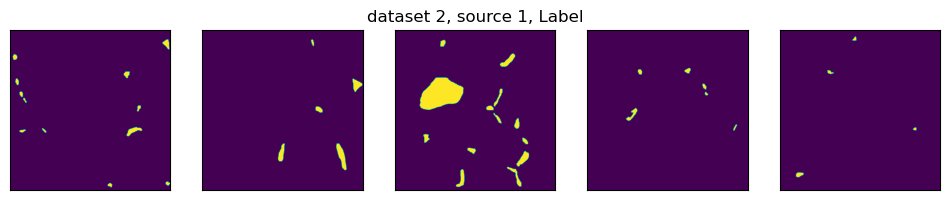

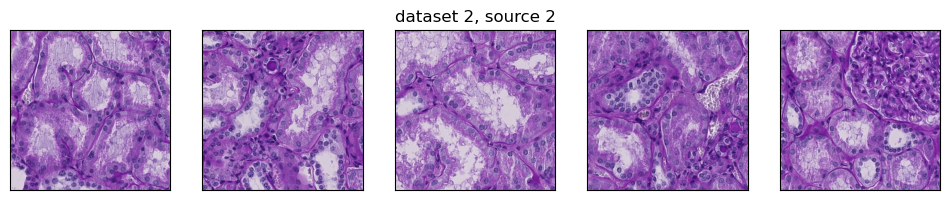

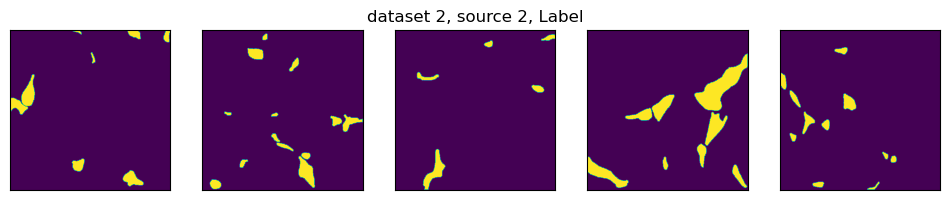

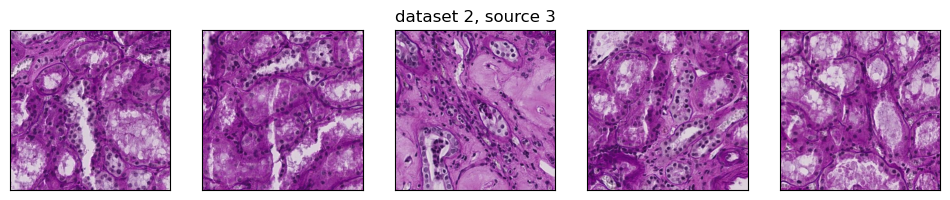

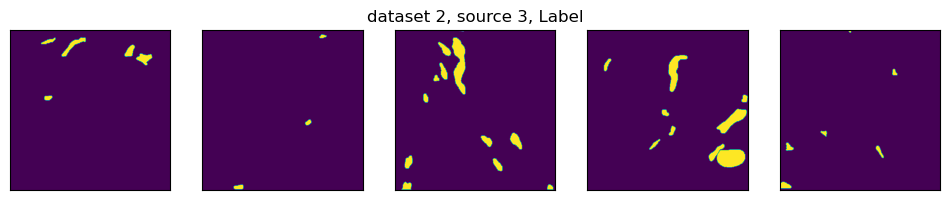

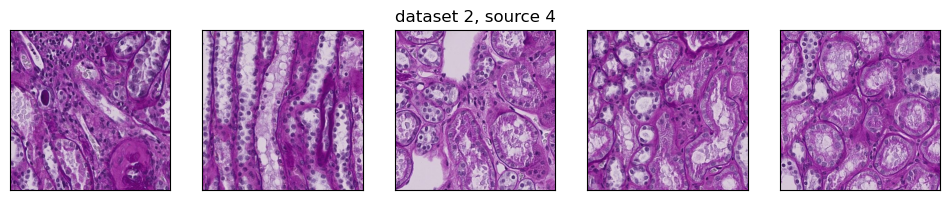

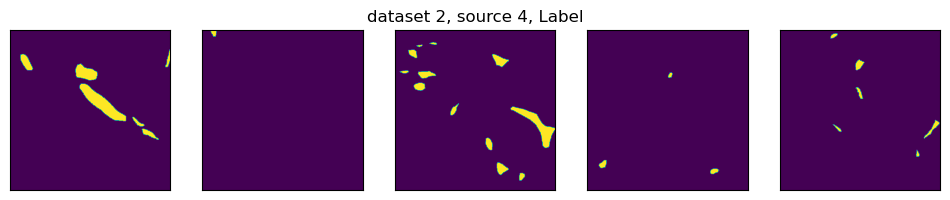

In [17]:
plot_photo(X_train[samples_ds[1][0][0:5]], "dataset 2, source 1")
plot_photo(label_mat[samples_ds[1][0][0:5]], "dataset 2, source 1, Label")

plot_photo(X_train[samples_ds[1][1][0:5]], "dataset 2, source 2")
plot_photo(label_mat[samples_ds[1][1][0:5]], "dataset 2, source 2, Label")

plot_photo(X_train[samples_ds[1][2][0:5]], "dataset 2, source 3")
plot_photo(label_mat[samples_ds[1][2][0:5]], "dataset 2, source 3, Label")

plot_photo(X_train[samples_ds[1][3][0:5]], "dataset 2, source 4")
plot_photo(label_mat[samples_ds[1][3][0:5]], "dataset 2, source 4, Label")

## 4.3 Data Imbalance

Since it was hard to clearly explain difference of distribution, following items are calculated by each image. Then distribution are plotted. 

* ratio of positive pixel (blood vessel)
* Mean size and quantity of blood vessel

The function `label_stat` calculates number of blood vessel and mean size of them. OpenCV's function `cv2.connectedComponents` takes boolean image as input, and count number of connected area, then it assigns label into each of them in 2D matrix. `densty_plot` and `scatter_plot` visualize ratio of positive pixels, mean size and quantity of blood vessels respectively.

In [18]:
def label_stat(Y_mat):
    
    #n_labels = number of labels
    # labels_mat= 2D matrix in which label of connected areas are assigned. 
    
    n_labels, labels_mat = cv2.connectedComponents(Y_mat)
    size_list = []
    for i in range(1, n_labels):
        #Calculate number of pixels for each label
        filter1 = labels_mat == i
        size = filter1.sum()
        size_list.append(size)

    return n_labels - 1, np.mean(size_list)


def density_plot(dataset, n_source):
    
    fig, ax = plt.subplots(1,n_source, figsize = (3.5*n_source,2.7))
    
    for i in range(n_source):
        filter1 = (tile_df["dataset"] == dataset) & (tile_df["source_wsi"] == i + 1)
        sns.kdeplot(tile_df["positive_ratio"].loc[filter1], ax = ax[i])
        ax[i].set_xlim(0, 0.5)
        ax[i].set_title("(dataset, source) = (" +str(dataset) + ", " + str(i+1)  + ")" )
        if i > 0:
            ax[i].set_ylabel("")
            
    plt.show()
    

def scatter_plot(dataset, n_source):
    fig, ax = plt.subplots(1,n_source, figsize = (3.5*n_source,2.7))

    for i in range(n_source):
        filter1 = (tile_df["dataset"] == dataset) & (tile_df["source_wsi"] == i + 1)
        sns.scatterplot(data = tile_df.loc[filter1], x =  "n_BloodVessel", y = "meanSize_BloodVessel", ax = ax[i], alpha = 0.4)
        ax[i].set_xlim(0, 35)
        ax[i].set_ylim(0, 15)
        if i > 0:
            ax[i].set_ylabel("")
        ax[i].set_title("(dataset, source) = (" +str(dataset) + ", " + str(i+1)  + ")" )
    
    ax[0].set_ylabel("mean size (1000 pixel)")
    plt.show()
    


In [19]:
n_label_list = []
mean_size_list = []
ratio_list = []
for i in range(NP):
    n_label, mean_size = label_stat(label_mat[i])
    n_label_list.append(n_label)
    mean_size_list.append(mean_size)
    ratio_list.append(np.mean(label_mat[i]))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
tile_df["n_BloodVessel"] = n_label_list
tile_df["meanSize_BloodVessel"] = np.array(mean_size_list)/1000
tile_df["positive_ratio"] = ratio_list

### Ratio of positive pixel

Overall, only 3.3% of pixels are positive (blood vessel). When it is calculated by each dataset and source, dataset 1 has more positive pixels than dataset 2.

In [21]:
pct = np.round(tile_df["positive_ratio"].mean()*100, 1)
print(pct, "% of pixels are positive in all data")

3.3 % of pixels are positive in all data


In [22]:
tile_df[["dataset", "source_wsi", "positive_ratio"]].groupby(["dataset", "source_wsi"]).mean()

positive_ratio
dataset source_wsi                
1       1                 0.048136
        2                 0.054572
2       1                 0.017804
        2                 0.033523
        3                 0.036642
        4                 0.015309

The ratio positive pixel is calculated by each image, and the distribution is plotted in following density plots.



**Dataset 1**

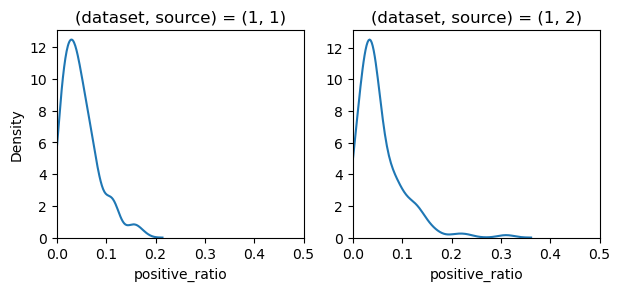

In [23]:
density_plot(1, 2)

**Dataset 2**

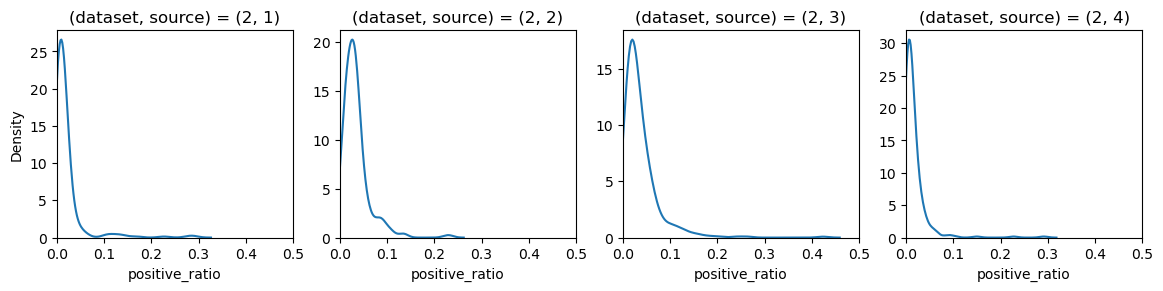

In [24]:
density_plot(2, 4)

### Size and quantity of Blood Vessels

Dataset 1 source 1 has different distribution from others. It has less number of blood vessels, but their size are larger. Please note that **one dot corresponds to one image** in scatterplots.

**dataset1**

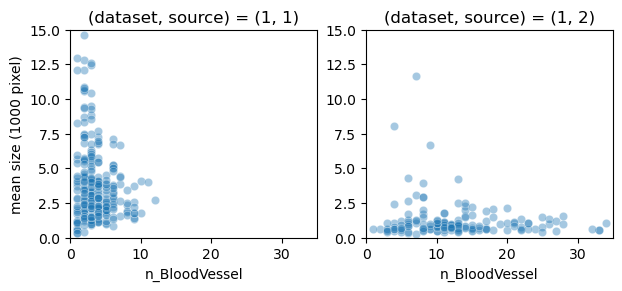

In [25]:
scatter_plot(1, 2)

**dataset2**

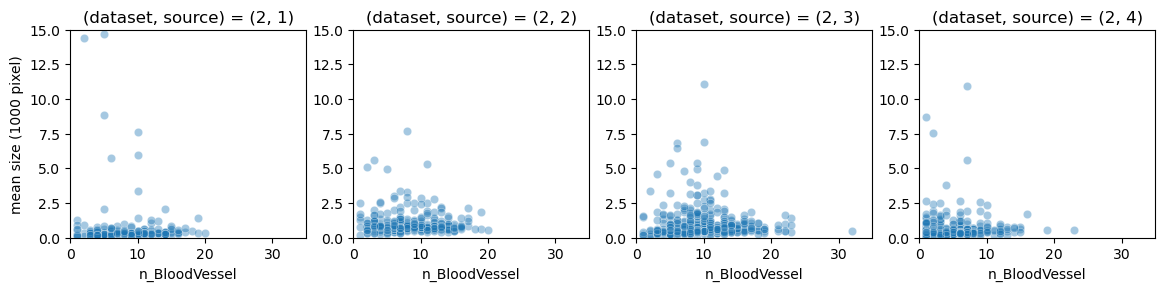

In [26]:
scatter_plot(2, 4)

# 5. Models

For image segmentation, Fully Convolutional Network and U-net are developed. Both of them are trained, then validation results are compared. 

## 5.1 FCN (Fully Convolutional Network)

Fully Convolutional Network (FCN) has two type of elements. First,`ConvBlock` which consists of `Conv2D` layer followed by `BatchNormalization` and `Relu`. It downsamples input by `MaxPooling2D` upon request. `ConvBlock` are allocated sequantially just like VGG16 or AlexNet architecture. 

Unlike architecture for image classificaiton, however, FCN does not have fully connected layer. Instead, it has `UpsampleBlock` which takes input of size 64x64x512, then generates 512x512x1 by `Conv2DTranspose`.

In [27]:
def ConvBlock(channel, X, ksize = 3, downsample = True):
    
    if downsample:
        X =  layers.MaxPooling2D(pool_size=(2, 2), strides = (2,2))(X)        
    
    X = layers.Conv2D(channel, kernel_size = ksize, strides = 1, padding = "same")(X)        
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    
    return X

def UpsampleBlock(channel, X, ksize, stride):
    
    X = layers.Conv2DTranspose(channel, kernel_size=ksize, strides=stride, padding ="same")(X)
        
    return X

In [28]:
def create_FCN():
    
    L = 512
    Input =  layers.Input(shape=(L, L, 3))
    
    X = layers.Rescaling(scale = 1./127.5, offset= -1, )(Input)
    
    KS = 3
    channel = 64
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#512
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    
    channel = channel*2
    X = ConvBlock(channel, X, ksize = KS, downsample = True)#256
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    channel = channel*2
    X = ConvBlock(channel, X, ksize = KS, downsample = True)#128
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    channel = channel*2
    X = ConvBlock(channel, X, ksize = KS, downsample = True)#64
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    X = ConvBlock(channel, X, ksize = KS, downsample = False)#
    
    
    X = UpsampleBlock(1, X, ksize = 8, stride = 8)

    model = Model(inputs = Input, outputs = X)
    
    return model

In [29]:
model_FCN = create_FCN()
model_FCN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 512, 512, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                             

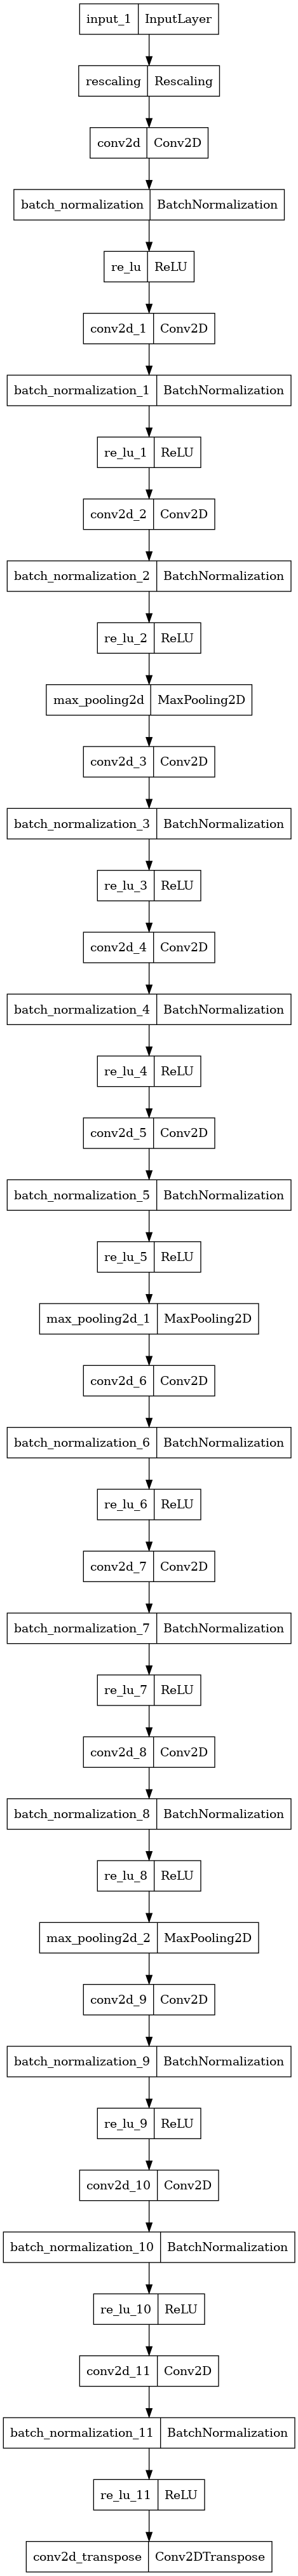

In [30]:
tf.keras.utils.plot_model(model_FCN)

## 5.2 U-NET

U-net is basically similar to convolutional autoencoders that have downsampling decoder and upsampling encoder. What makes U-net unique is **skip connection from decoder to encoder at each level**. This structure looks similar to [V-model](https://en.wikipedia.org/wiki/V-model). 

`LeftBlock` written in the below code has `Conv2D` followed by `BatchNormalization` and `Relu`. It downsamples input by `MaxPooling2D` upon request. `RightBlock` upsamples input by `Conv2DTranspose` and it is concatenated with skip connection from `LeftBlock`. It is actually simple when plotted in the figure. 

In [31]:
def LeftBlock(channel, X, ksize = 3, downsample = True):
    
    if downsample:
        X =  layers.MaxPooling2D(pool_size=(2, 2), strides = (2,2))(X)
            
    X = layers.Conv2D(channel, kernel_size = ksize, strides = 1, padding = "same")(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    
    return X


def RightBlock(channel, X, ksize = 3, X_skip = None, upsample = True):
    
    if upsample:
        X = layers.Conv2DTranspose(channel, kernel_size=4, strides=2, padding="SAME")(X)
    
    if X_skip is not None:
        X = layers.Concatenate()([X, X_skip])
    
    X =  layers.Conv2D(channel, kernel_size = ksize, strides = 1, padding = "same")(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)

    return X

In [32]:
def create_UNET():
    
    L = 512
    Input =  layers.Input(shape=(L, L, 3))

    X0 = layers.Rescaling(scale = 1./127.5, offset= -1, )(Input)
    
    KS = 5
    
    channel = 48
    X1 = LeftBlock(channel, X0, ksize = KS, downsample = False)#512

    channel = channel*2 #128
    X2 = LeftBlock(channel, X1, ksize = KS, downsample = True)#256

    channel = channel*2 #256
    X3 = LeftBlock(channel, X2, ksize = KS, downsample = True)#128
    
    channel = channel*2 #512
    X4 = LeftBlock(channel, X3, ksize = KS, downsample = True)#64

    channel = channel #512
    X5 = LeftBlock(channel, X4, ksize = KS, downsample = True)#32
    
    XR = RightBlock(channel, X5, ksize = KS, X_skip = X4) #64

    channel = int(channel/2) #256
    XR = RightBlock(channel, XR, ksize = KS, X_skip = X3) #128

    channel = int(channel/2) #128
    XR = RightBlock(channel, XR, ksize = KS, X_skip = X2) #256

    channel = int(channel/2) #64
    XR = RightBlock(channel, XR, ksize = KS, X_skip = X1) #512

    channel = 1
    XR = layers.Conv2D(channel, kernel_size = 1, strides = 1, padding = "same")(XR)

    model = Model(inputs = Input, outputs = XR)
    
    return model

In [33]:
model_UNET = create_UNET()
model_UNET.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 512, 512, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 48  3648        ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

**Figure of U-net**

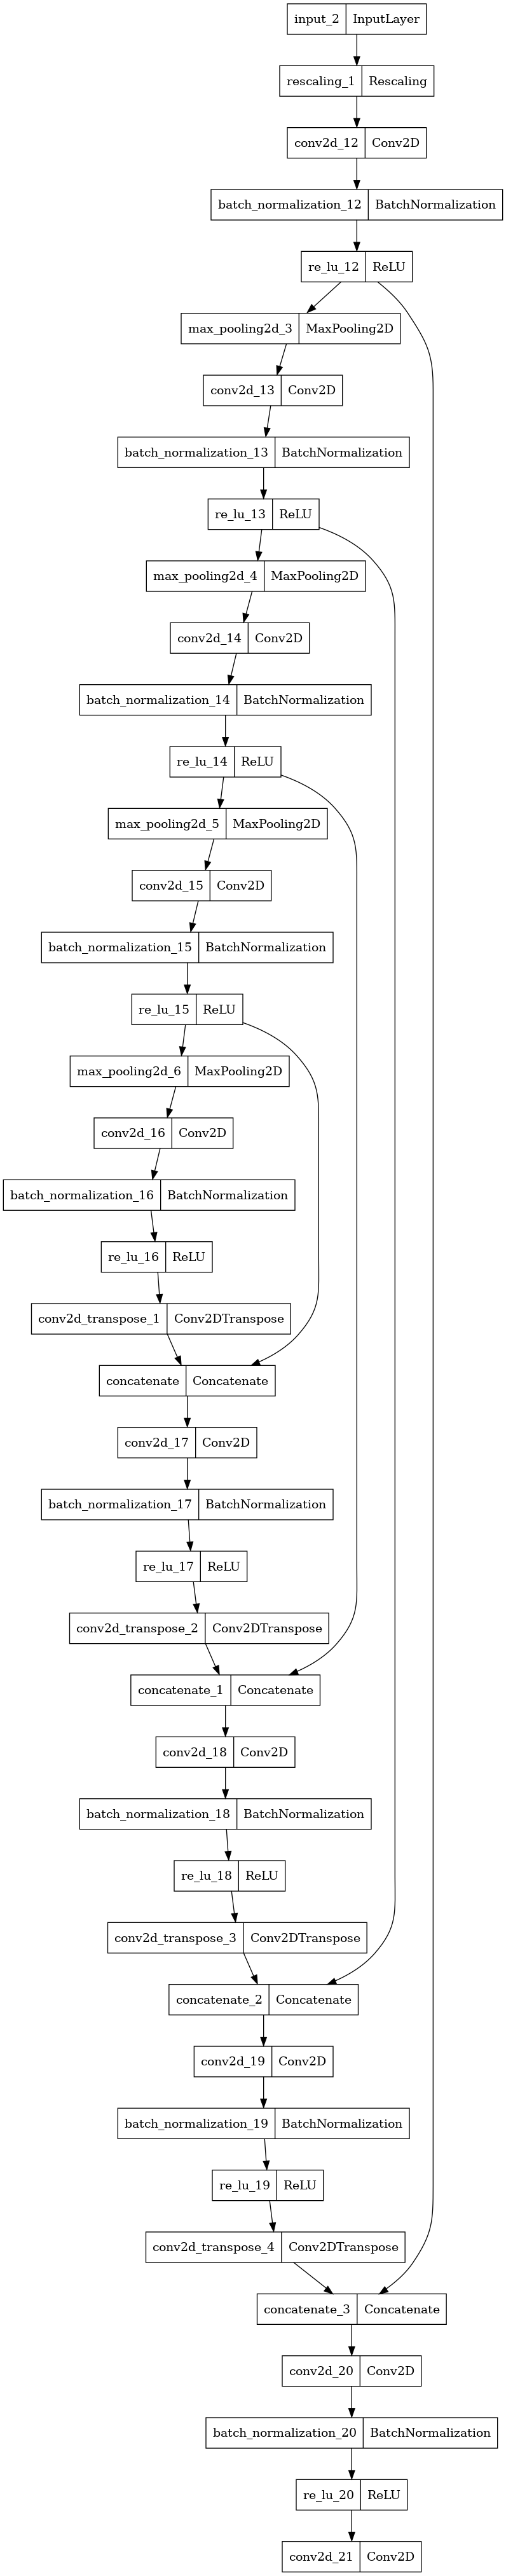

In [34]:
tf.keras.utils.plot_model(model_UNET)

# 6. Training and Hyperparameter Tuning

## 6.1 Split Dataset

80% of image is randomly selected for training. 

In [35]:
batch_size = 4

In [36]:
np.random.seed(1)

n_data = NP
n_train = int(n_data*0.8)

all_idx = np.arange(n_data)
np.random.shuffle(all_idx)

train_idx = all_idx[:n_train]
val_idx = all_idx[n_train:]

print("N of data for training = ", train_idx.shape[0]) 
print("N of data for validation = ", val_idx.shape[0])

N of data for training =  1306
N of data for validation =  327


In [37]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train[train_idx], label_mat[train_idx])).shuffle(1000).batch(batch_size)

X_val = X_train[val_idx]
Y_val = label_mat[val_idx]
n_val = X_val.shape[0]

`val_tile_df` is later used to analyze validation result.

In [38]:
val_tile_df = tile_df.iloc[val_idx].reset_index()

## 6.2 Custom Loss Function

Since the label is imbalanced (refer to chapter 4 EDA), simple binary cross entropy would not work well. Instead, this `custom_loss` function calculate binary cross entropy for positive and negative pixels separately. Because tesorflow's `BCE` contains reduce_mean function, positive and negative losses can be balanced in this way. It is same as **weighted log loss**
Then, positve loss and negative loss are summed with **weight of negative loss**. When the weight of negative loss is 2 or 3 , the result was good. 

In [39]:
# Custom Loss Function

BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def custom_loss(y_true, y_pred):

    filter1 = y_true == 1

    p_loss = BCE(y_true[filter1], y_pred[filter1])

    filter1 = y_true == 0
    n_loss = BCE(y_true[filter1], y_pred[filter1])

    loss =  p_loss + n_loss*3 #weighted log loss

    return loss

## 6.3 Image Augmentation

The funciton `augment` is applied to both image and label, because when image is flipped, label shall follow it. First part of augmentation is **horizontal and vertical flip** at probability 0.5 respectively. Next is image rotation. **The rotation angle is selected from 0, 90, 180 and 270**. Finally, **the image and the label is zoomed** at 0.3 probability. It select uppler left pixel randomly. Then the length is selected. It is clipped and resized to 512x512. 

In [40]:
#Image Augment Function
def augment(X, Y):
    
    #1. random flip--------------
    #1.1 horizontal
    if tf.random.uniform(shape=[1]) > 0.5:
        X = X[:,:,::-1]
        Y = Y[:,:,::-1]
        
    #1.2 vertical
    if tf.random.uniform(shape=[1]) > 0.5:
        X = X[:,::-1]
        Y = Y[:,::-1]
    
    #2. rotation------------------
    #2.1 set angle 
    angle = np.random.randint(4) 
    X = tf.image.rot90(X, k=angle)
    Y = tf.image.rot90(Y, k=angle)
    
    #3. zoom -----------------------------
    L = 512
    if tf.random.uniform(shape=[1]) < 0.3:
        
        #left upper
        x1 = np.random.choice(np.arange(0, int(L*0.2)), 1)[0]
        y1 = np.random.choice(np.arange(0, int(L*0.2)), 1)[0]
        
        #Length
        L2 = min(L-x1, L-y1)
        L3 = np.random.choice(np.arange(int(L2*0.8), L2), 1)[0]
        
        X = X[:,y1:(y1+L3), x1:(x1+L3),:] 
        Y = Y[:,y1:(y1+L3), x1:(x1+L3),:] 
        
        X = tf.cast(tf.image.resize(X,[L, L]), dtype = tf.uint8)
        Y = tf.cast(tf.image.resize(Y,[L, L]), dtype = tf.uint8)
    
    return X, Y

## 6.4 Custom train loop

The custom train loop `train_loop` consists of `augment` fuction, `train_step` which calculates loss and apply gradients, and some functions to calculate validation results (`cal_IoU`, `predict_probability`, `val_score`). The statement `@tf.function` before the `train_step` significantly accelerates training by creating computation graph. Furthermore, to keep the best model, `train_loop` saves trained model when validation loss is the lowest. 

In [41]:
@tf.function
def train_step(X, Y, model):
        
    with tf.GradientTape() as tape:
        Y_pred = model(X)
        loss = custom_loss(Y, Y_pred)
        
        
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss

In [42]:
#calculate IoU from predicted prob
def cal_IoU(Y_true, prob, cutoff = 0):
    
    Y_pred = (prob > cutoff).astype(int)
    
    score_list = []
    for k in range(prob.shape[0]):
    
        and_score =  np.sum(Y_pred[k][Y_true[k] == 1])
        or_score = np.sum(Y_true[k]) + np.sum(Y_pred[k]) - and_score
        
        
        if or_score == 0:
            score = 1
        else:
            score = and_score/or_score
        score_list.append(score)
    
    return np.round(np.mean(np.array(score_list)), 3) 


#calculation of probability from logit
def predict_probability(X, model):
    pred = model.predict(X, verbose = 0)
    odd = np.exp(pred)
    prob = odd/(1+odd)
    
    return prob
    
# validation loss 
def val_score(X, Y, model):
    
    Y_pred = model.predict(X)
    loss =  custom_loss(Y, Y_pred)
    
    return loss

In [43]:
def train_loop(n_epoch, history, model, model_name, print_result = True):
    
    best_val_loss = 100000.
    
    for k in range(n_epoch):
        
        time1 = time.time()
        
        loss_list = []
        for _, ds in enumerate(train_ds):
            X, Y = ds #to extract X and Y from dataset

            X, Y = augment(X, Y) #image augmentation
            
            loss = train_step(X, Y, model) #calculate loss and apply gradients
            loss_list.append(loss)
        
        #recording loss
        train_loss = np.mean(loss_list)    
        val_loss = val_score(X_val, Y_val, model)
        
        #calculate IoU
        prob = predict_probability(X_val, model)
        val_IoU = cal_IoU(Y_val, prob, 0.8)
        
        #records loss and IoU in history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_IoU"].append(val_IoU)
        
        time2 = time.time()
        time3 = np.round(time2- time1)
        
        if k >= 0:
            #keep saving the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                model.save_weights(model_name + "/ckpt1")
                print("write model at epoch ", k)
        
        if print_result:
            print(k, "train loss", train_loss, ", val loss ", val_loss, ", val_IoU", val_IoU, " time[s] = ", time3)

In [44]:
#This is the function to save train and validation history.
def save_history(history, model_name):
    
    np.save("train_loss_" + model_name, np.array(history["train_loss"]))
    np.save("val_loss_" + model_name, np.array(history["val_loss"]))
    np.save("val_IoU_" + model_name, np.array(history["val_IoU"]))

## 6.5 Hyperparameter Tuning

After running notebooks many times, following hyperparameters were tuned. Only the results are shown here, because demonstrating all the process is not possible within limited calculation time. 

**General**

* adam optimizer with learning rate = 0.0002. (much better than default lr 0.001) with batch size = 4
* weight of negative loss (false positive) in `custom_loss` = 3
* best epoch: 20 ~ 30 

**FCN**
* Number of conv block at each level = 3
* Convolution kernel size = 3

**U-NET**
* Number of conv block at each level = 1
* Convolution kernel size = 5

## 6.6 Training FCN

**This model is previously trained in the notebook to avoid OutOfMemoryError**, because training two models in one notebook was not possible. It loads trained results.

In [45]:
history_FCN = {}
history_FCN["train_loss"] = []
history_FCN["val_loss"] = []
history_FCN["val_IoU"] = []

In [46]:
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0002)

In [47]:
#train_loop(20, history_FCN, model_FCN, "HuBMAP-FCN-model")

In [48]:
#save_history(history_FCN, "FCN")

**import trained model and result**

In [49]:
model_FCN.load_weights("/kaggle/input/hubmap-reportfiles/fcn_model/ckpt1")

In [50]:
history_FCN["train_loss"] = np.load("/kaggle/input/hubmap-reportfiles/fcn_loss/train_loss_FCN.npy")
history_FCN["val_loss"] = np.load("/kaggle/input/hubmap-reportfiles/fcn_loss/val_loss_FCN.npy")
history_FCN["val_IoU"] = np.load("/kaggle/input/hubmap-reportfiles/fcn_loss/val_IoU_FCN.npy")

In [51]:
def plot_history(history):
    
    fig, ax = plt.subplots(figsize = (5,4))
    ax.plot(history["train_loss"], label = "train loss")    
    ax.plot(history["val_loss"], label = "val loss")
    ax.set_title("loss")
    ax.legend()
    ax.grid()
    #fig, ax = plt.subplots(1,2, figsize = (10,4))
    #ax[0].plot(history["train_loss"], label = "train loss")    
    #ax[0].plot(history["val_loss"], label = "val loss")
    
    #ax[1].plot(history["val_IoU"])
    #ax[0].set_title("loss")
    #ax[0].legend()
    #ax[1].set_title("val IoU (in all images)")
    #ax[0].grid()
    #ax[1].grid()

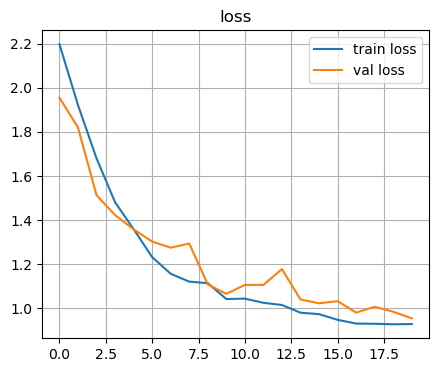

In [52]:
plot_history(history_FCN)

## 6.7 Training U-NET

**This model is previously trained in the notebook to avoid OutOfMemoryError**, because training two models in one notebook was not possible. It loads trained results. 

In [53]:
history_UNET = {}
history_UNET["train_loss"] = []
history_UNET["val_loss"] = []
history_UNET["val_IoU"] = []

In [54]:
#train_loop(20, history_UNET, model_UNET, "HuBMAP-UNET-model")

In [55]:
#save_history(history_UNET, "UNET")

**import trained result**

In [56]:
model_UNET.load_weights("/kaggle/input/hubmap-reportfiles/unet_model/ckpt1")

In [57]:
history_UNET["train_loss"] = np.load("/kaggle/input/hubmap-reportfiles/unet_loss/train_loss_UNET.npy")
history_UNET["val_loss"] = np.load("/kaggle/input/hubmap-reportfiles/unet_loss/val_loss_UNET.npy")
history_UNET["val_IoU"] = np.load("/kaggle/input/hubmap-reportfiles/unet_loss/val_IoU_UNET.npy")

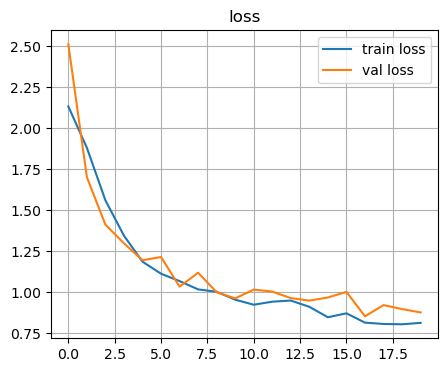

In [58]:
plot_history(history_UNET)

# 7. Analysis of Validation Result

## 7.1 Validation Loss

There are lots of ways to analyse results. First, validation loss of both models are compared. According to the plots, both model learned well but U-NET has slightly smaller loss than FCN.

In [59]:
def compare_val(history_FCN, history_UNET):
    
    fig, ax = plt.subplots(figsize = (6, 5))
    ax.plot(history_FCN["val_loss"], label = "FCN val loss")
    ax.plot(history_UNET["val_loss"], label = "U-NET val loss")
    ax.set_title("val loss")
    ax.grid()
    ax.legend()
    plt.show()

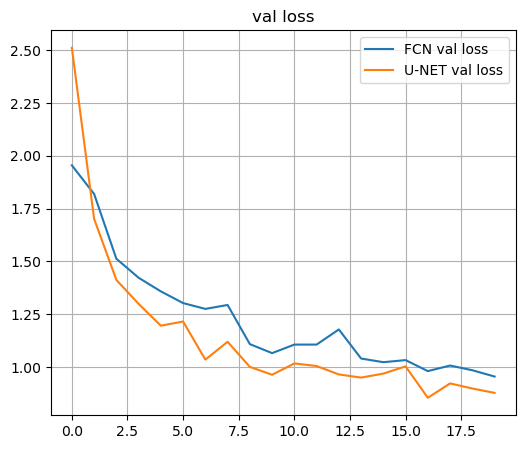

In [60]:
compare_val(history_FCN, history_UNET)

## 7.2 Predicted labels

Since both of FCN and U-net trained well, they must be able to predict label with good accuracy. The funciton `plot_result` visualize an image, its label, and prediction results by FCN and U-net.

In [61]:
def plot_result(X, Y_true, Y_pred1, Y_pred2, cutoff = 0.8):
    
    N = X.shape[0]
    
    fig, ax = plt.subplots(N,6, figsize = (13,2.2*N))
    
    for k in range(N):
        
        cutoff_img1 = (Y_pred1[k,:,:,0] > cutoff).astype(int)
        cutoff_img2 = (Y_pred2[k,:,:,0] > cutoff).astype(int)

        true_img = np.zeros((512, 512, 3), dtype = np.uint8)
        true_img[:,:,1] = Y_true[k,:,:,0]*200
        
        cutoff1 = np.zeros((512, 512, 3), dtype = np.uint8)
        cutoff2 = np.zeros((512, 512, 3), dtype = np.uint8)
        
        cutoff1[:,:,0] = cutoff_img1*230
        cutoff2[:,:,0] = cutoff_img2*230
        
        cutoff1[:,:,1] = cutoff_img1*50
        cutoff2[:,:,1] = cutoff_img2*50
        cutoff1[:,:,2] = cutoff_img1*50
        cutoff2[:,:,2] = cutoff_img2*50
        
        diff_photo1 = cutoff1.copy()
        diff_photo2 = cutoff2.copy()
        diff_photo1[:,:,1] += Y_true[k,:,:,0]*200
        diff_photo2[:,:,1] += Y_true[k,:,:,0]*200
        
        ax[k, 0].imshow(X[k])
        ax[k, 1].imshow(true_img, cmap = "gray")
        ax[k, 2].imshow(cutoff1, cmap = "gray")
        ax[k, 3].imshow(diff_photo1)
        ax[k, 4].imshow(cutoff2, cmap = "gray")
        ax[k, 5].imshow(diff_photo2)
        
        for j in range(6):
            ax[k,j].set_xticks([])
            ax[k,j].set_yticks([])
    
        if k == 0:
            ax[k, 0].set_title("val img")
            ax[k, 1].set_title("true label")
            ax[k, 2].set_title("FCN (cutoff at 0.8)")
            ax[k, 3].set_title("Compare (Y:tp)")
            ax[k, 4].set_title("UNET (cutoff at 0.8)")
            ax[k, 5].set_title("Compare (Y:tp)")

In [62]:
np.random.seed(5)
val_sample = np.random.choice(n_val, 10)
val_sample

array([206, 189, 118,  73,   8, 228, 231, 112, 158, 208])

**Prediction by FCN**

In [63]:
time1 = time.time()

#prob_val_FCN = predict_probability(X_val[val_sample], model_FCN)
prob_val_FCN = predict_probability(X_val, model_FCN)
time2 = time.time()

val_time_FCN = np.round((time2 - time1), 2)
print(val_time_FCN, "sec")

43.18 sec


**Prediction by U-NET**

In [64]:
time1 = time.time()
#prob_val_UNET = predict_probability(X_val[val_sample], model_UNET)
prob_val_UNET = predict_probability(X_val, model_UNET)
time2 = time.time()

val_time_UNET = np.round((time2 - time1), 2)
print(val_time_UNET, "sec")

35.85 sec


**Results**

Ten of prediction resutls are shown below. Apparently, both models predict somewhat well, although it is not simple task. The true label is **green** and the predicted label is **red**. Predicted label is created by cutting off predicted probability at 0.8. When both are plotted in the same image (refer to **Compare (Y:tp)**), true positive becomes **yellow**. Precisions of prediction are varied, some are very well predicted but some are not. The next question would be "Does the result depend on dataset?" 

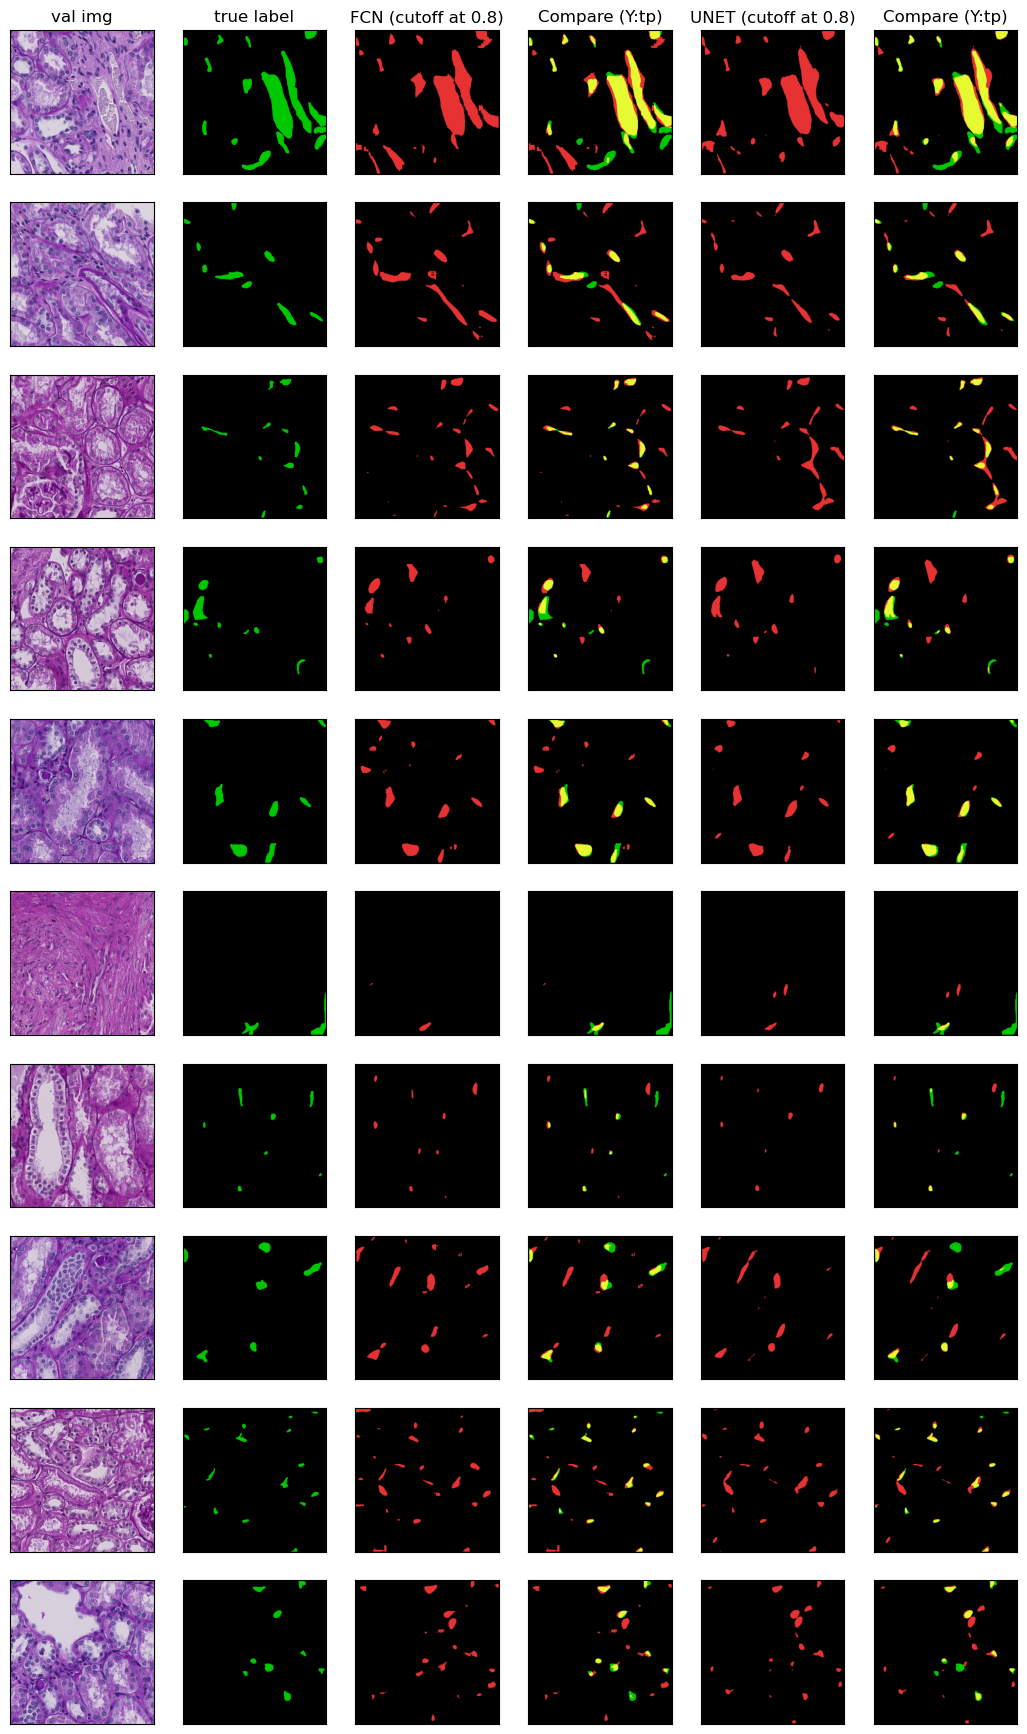

In [65]:
#plot_result(X_val[val_sample], Y_val[val_sample], prob_val_FCN, prob_val_UNET)
plot_result(X_val[val_sample], Y_val[val_sample], prob_val_FCN[val_sample], prob_val_UNET[val_sample])

## 7.3 Average IoU

Finally, the average IoU is calculated: predict label, calculate IoU of an image, then take mean of them. Overall, both **FCN and U-NET achieved the target: Average IoU > 0.5 in validation**. When it is calculated by datasets/sources, however, both models did not achieve 0.5 in dataset1 source2. The reason could be lack of quantity of dataset1 source2 (refer to the chapter 4 EDA, section 4.1 Basic Information). To figure out the relationship between number of images and validation scores, scatterplot `Average IoU vs train image quantity` are created. Those are kind of correlated.  

In [66]:
IoU_FCN_list = []
IoU_UNET_list = []
for i in range(n_val):
    val1 = cal_IoU(Y_val[i], prob_val_FCN[i], cutoff = 0.8)
    val2 = cal_IoU(Y_val[i], prob_val_UNET[i], cutoff = 0.8)
    IoU_FCN_list.append(val1)
    IoU_UNET_list.append(val2)

In [67]:
val_tile_df["IoU_FCN"] = IoU_FCN_list
val_tile_df["IoU_UNET"] = IoU_UNET_list

**Average IoU**

In [68]:
val_tile_df[["IoU_FCN", "IoU_UNET"]].mean()

IoU_FCN     0.548752
IoU_UNET    0.580156
dtype: float64

**Average IoU by dataset/source**

In [69]:
mean_IoU_df = val_tile_df[["dataset", "source_wsi", "IoU_FCN", "IoU_UNET"]].groupby(["dataset", "source_wsi"]).mean()
mean_IoU_df

IoU_FCN  IoU_UNET
dataset source_wsi                    
1       1           0.561961  0.603059
        2           0.446719  0.472781
2       1           0.620977  0.642860
        2           0.518845  0.542293
        3           0.540176  0.568165
        4           0.582362  0.628207

In [70]:
select = ["dataset", "source_wsi", "count"]
sum_train_df = tile_df[select].iloc[train_idx].groupby(select[0:-1]).sum().astype(int)

In [71]:
sum_train_df = sum_train_df.reset_index()
sum_train_df["text"] = sum_train_df.apply(lambda x: "d" +str(x["dataset"]) +", s" + str(x["source_wsi"]) , axis = 1) 
sum_train_df = sum_train_df.merge(mean_IoU_df, on = ["dataset", "source_wsi"])

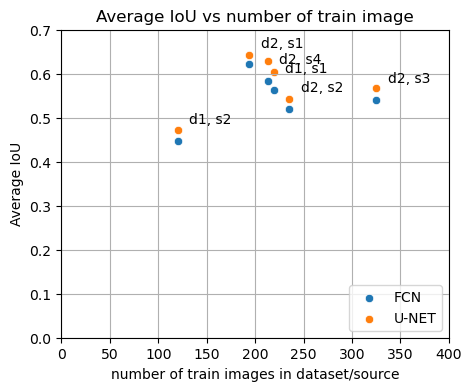

In [72]:
fig, ax = plt.subplots(figsize = (5, 4))
sns.scatterplot(data =sum_train_df, x = "count", y = "IoU_FCN", ax =ax, label = "FCN")
sns.scatterplot(data =sum_train_df, x = "count", y = "IoU_UNET", ax = ax, label = "U-NET")

for i in range(sum_train_df.shape[0]):
    ax.text(x = sum_train_df["count"].iloc[i] + 12, y = sum_train_df["IoU_FCN"].iloc[i] + 0.04, s= sum_train_df["text"].iloc[i])
ax.set_xlabel("number of train images in dataset/source")
ax.set_ylabel("Average IoU")
ax.grid()
ax.set_xlim(0, 400)
ax.set_ylim(0, 0.7)
ax.set_title("Average IoU vs number of train image")
ax.legend(loc = 4)
fig.show()

## 7.4 IoU Distribution

Those density plots shows IoU Distribution. First one is overall distribution, and latter ones are by dataset/source. For both models, They are normally distributed.

Text(0.5, 1.0, 'Validation IoU distribution')

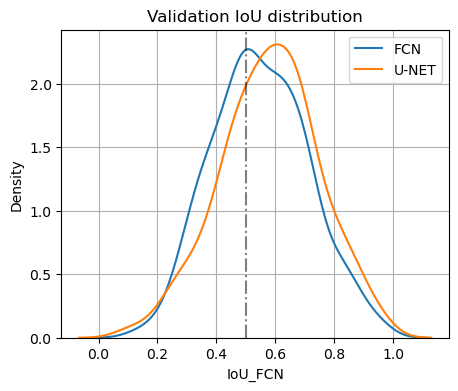

In [73]:
fig, ax = plt.subplots(figsize =(5, 4))
sns.kdeplot(val_tile_df["IoU_FCN"], ax = ax, label = "FCN")
sns.kdeplot(val_tile_df["IoU_UNET"], ax = ax, label = "U-NET")
ax.grid()
ax.legend()
ax.axvline(x = 0.5, ls = "-.", color = "black", alpha = 0.5)
ax.set_title("Validation IoU distribution")

In [74]:
def val_density_plot(dataset, n_source):
    
    fig, ax = plt.subplots(1,n_source, figsize = (3.5*n_source,2.7))
    
    for i in range(n_source):
        filter1 = (val_tile_df["dataset"] == dataset) & (val_tile_df["source_wsi"] == i + 1)
        sns.kdeplot(val_tile_df["IoU_FCN"].loc[filter1], label = "FCN IoU", ax = ax[i])
        sns.kdeplot(val_tile_df["IoU_UNET"].loc[filter1], label = "UNET IoU", ax = ax[i])
        ax[i].set_xlim(0, 1)
        ax[i].set_title("(dataset, source) = (" +str(dataset) + ", " + str(i+1)  + ")" )
        ax[i].legend()
        ax[i].set_xlabel("Val IoU")
        ax[i].axvline(x = 0.5, ls = "-.", color = "black", alpha = 0.5)
        if i > 0:
            ax[i].set_ylabel("")
            
            
    plt.show()

for dataset1/source1, U-NET has peak greater than 0.6.

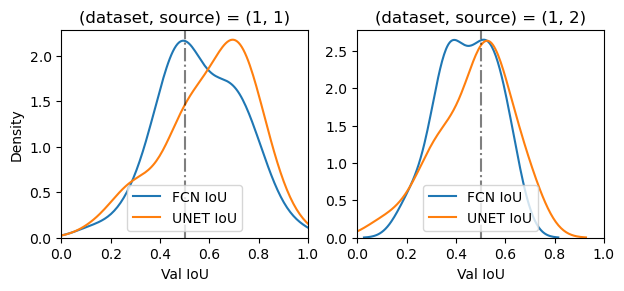

In [75]:
val_density_plot(1, 2)

For dataset2/source1, both models have peak greather than 0.6.

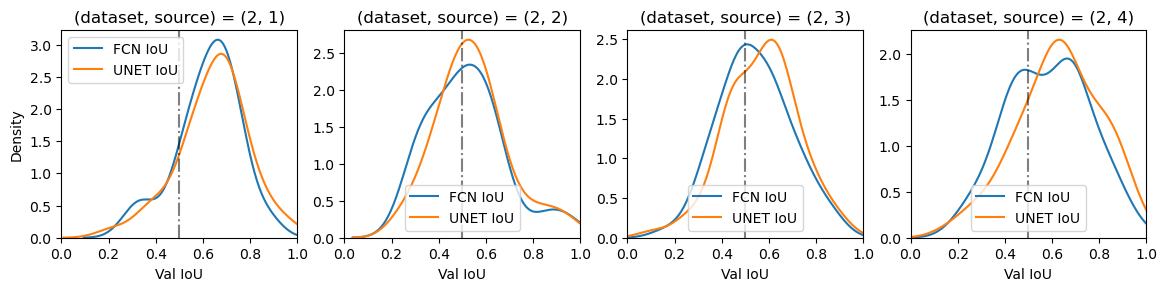

In [76]:
val_density_plot(2, 4)

# 8. Kaggle Score

## 8.1 Evaluation Metric

This competition adopted different metric for scoring. 

*Submissions are evaluated by computing the **Average Precision over confidence** scores. ... Segmentation is calculated using **IoU with a threshold of 0.6**.*

https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview/evaluation

Unlike Average IoU, this metric calculate **true positive and false positive for each blood vessel**. **True positive of a blood vessel means IoU > 0.6**. For example, when there are multiple blood vessels closely exist and predicted connected labels are connected, then it counted as false positive. 

## 8.2 How I submitted

Using U-NET or FCN accompanies following additional procedures (**step1 - step3**). Those who applied Mask-RCNN or YOLO does not need step1 - step3. 

Step1: To cutoff low probability in predicted mask at threshold 0.8~0.84 (tuned before every submission by IoU). 

Step2: To identify all predicted blood vessels indivisually by `cv2.connectedComponents`

Step3: To calculate **mean probability of each component**. It is confidence of prediction required by the competition. 

Step4: To encode every predicted label using the provided function [`encode_binary_mask`](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview/evaluation)

Step5: To submit the encoded labels with confidences.

## 8.3 Kaggle Score

Both models are trained by 95% of given image, and max_epoch is 35, and the models with lowest validation loss are selected.
Then kaggle private scores are: 

* FCN: 0.264
* U-NET: 0.255

# 9. Conclusion

This project achieved avrage IoU in validation > 0.5 by both FCN and U-NET. First, **EDA discovered imbalance in label** and difference of distribution between datasets/source. Based on EDA, **custom loss function is developed to increase importance of positive labels** which are small in images. **Image augmentation consists horizontal&vertical flip, rotation, and random zoom**, because those operations do not collapse the context (there must be no definitive direction of tissues). It was effective to privent overfitting when there are no plenty of images (only 1600 images are given). 

Both FCN and U-NET took nearly similar computation time in validation: 25~45sec. However, training of FCN was much faster than U-NET. FCN took one epoch for 100sec, whereas U-NET took 210sec, because architectre of FCN is much simpler and number of parameters are be smaller. On the otherhand, U-NET got smaller validation loss at every epoch. Thus, the best architecture depends on circumstances.

**What did not work well**

Following attemps did not improve results:

* random brightness change 
* transfer learning from VGG16 trained with imagenet dataset

Random brightness change is one of typical auguentation, but merely worsened both validation and kaggle score. The reason should be small variation of brightness in dataset.

**Ideas for improvement**

Chapter 7.3 revealed that validation score was worst in dataset1/source2, likely due to its small number of images. Since four images were randomly selected for a batch of training input (batch size = 4), dataset1/source2 had relatively less chance to be selected. In this case, **selecting images by equal probability from datasets/source** rectifies this imbalance of training that could improve precision. 



# References

[1] Fully Convolutional Networks for Semantic Segmentation, Jonathan Long, Evan Shelhamer, Trevor Darrell, UC Berkeley: https://arxiv.org/abs/1411.4038

[2] U-Net: Convolutional Networks for Biomedical Image Segmentation, Olaf Ronneberger, Philipp Fischer, Thomas Brox, Computer Science Department and BIOSS Centre for Biological Signalling Studies,
University of Freiburg, Germany: https://arxiv.org/abs/1505.04597